By: 顾 瞻 GU Zhan (Sam)

July 2017

# [1] Import useful reference packages

In [1]:
# from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import operator
from scipy import interp
from itertools import cycle
from sklearn import svm
from sklearn.utils.validation import check_random_state
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc
from statsmodels.graphics.mosaicplot import mosaic
print(__doc__)

Automatically created module for IPython interactive environment


### Read raw data

In [2]:
df_history_ts_process = pd.read_csv('data/history_ts.csv') 
df_history_ts_process.tail()

,ccyy-mm,time,bid-price
1886,2017-07,11:29:56,92100
1887,2017-07,11:29:57,92100
1888,2017-07,11:29:58,92100
1889,2017-07,11:29:59,92200
1890,2017-07,11:30:00,92200


In [3]:
df_history_table_process = pd.read_csv('data/history_table.csv') 
df_history_table_process.tail()

,ccyy-mm,volume-plate,deal-price-low,deal-price-avg,deal-early-second,volume-bidder
26,2017-03,10356,87800,87916,55,262010
27,2017-04,12196,89800,89850,59,252273
28,2017-05,10316,90100,90209,55,270197
29,2017-06,10312,89400,89532,45,244349
30,2017-07,10325,92200,92250,57,269189


# [2] Data pre-porcessing
Explore and visualize data

### Parameters

In [4]:
parm_calculate_base_price_second = 15 # Use the current month's bid-price as base-price at this seconds. Later to derive increment-price
parm_calculate_target_second = 7 # How many seconds in future to predict: target variable
parm_calculate_prev_bp = 15 # Number of previous price/increment to include, i.e. previous 2sec, 3sec, 4sec, 5sec ... 15sec
parm_calculate_mv = 15 # Number of  previous price/increment Moving Average to calculate, i.e. previous 2sec, 3sec, 4sec, 5sec ... 15sec
parm_calculate_prev_month = 3 # Number of previous month to include (need to remove earliest x month from training data)
print('parm_calculate_base_price_second : %3d seconds' % parm_calculate_base_price_second)
print('parm_calculate_target_second     : %3d seconds' % parm_calculate_target_second)
print('parm_calculate_prev_bp           : %3d seconds' % parm_calculate_prev_bp)
print('parm_calculate_mv                : %3d seconds' % parm_calculate_mv)
print('parm_calculate_prev_month        : %3d months' % parm_calculate_prev_month)

print('' )
parm_ts_cycle = 61 # seconds/records per month
print('parm_ts_cycle                    : %3d seconds' % parm_ts_cycle)
parm_ts_month = int(len(df_history_ts_process) / parm_ts_cycle)
print('parm_ts_month                    : %3d months' %  parm_ts_month)

parm_record_cut_row_head = max(parm_calculate_base_price_second, parm_calculate_prev_bp, parm_calculate_mv)
parm_record_cut_row_tail = parm_calculate_target_second
parm_record_cut_month_head = parm_calculate_prev_month + 1

parm_ts_valid_cycle = parm_ts_cycle - parm_record_cut_row_head - parm_record_cut_row_tail
print('parm_ts_valid_cycle              : %3d seconds' % parm_ts_valid_cycle)
parm_ts_valid_month = parm_ts_month - parm_record_cut_month_head
print('parm_ts_valid_month              : %3d months' % parm_ts_valid_month)

if parm_record_cut_month_head < 10:
    parm_record_cut_ccyy = pd.to_datetime('2015-0'+str(parm_record_cut_month_head))
else:
    parm_record_cut_ccyy = pd.to_datetime('2015-'+str(parm_record_cut_month_head))

print('' )
print('parm_record_cut_ccyy             : %s' % parm_record_cut_ccyy)

print('parm_record_cut_month_head       : %3d months' % parm_record_cut_month_head)
print('parm_record_cut_row_head         : %3d seconds' % parm_record_cut_row_head)
print('parm_record_cut_row_tail         : %3d seconds' % parm_record_cut_row_tail)
print('' )





parm_calculate_base_price_second :  15 seconds
parm_calculate_target_second     :   7 seconds
parm_calculate_prev_bp           :  15 seconds
parm_calculate_mv                :  15 seconds
parm_calculate_prev_month        :   3 months

parm_ts_cycle                    :  61 seconds
parm_ts_month                    :  31 months
parm_ts_valid_cycle              :  39 seconds
parm_ts_valid_month              :  27 months

parm_record_cut_ccyy             : 2015-04-01 00:00:00
parm_record_cut_month_head       :   4 months
parm_record_cut_row_head         :  15 seconds
parm_record_cut_row_tail         :   7 seconds



In [5]:
df_history_ts_process.head()

,ccyy-mm,time,bid-price
0,2015-01,11:29:00,74000
1,2015-01,11:29:01,74000
2,2015-01,11:29:02,74000
3,2015-01,11:29:03,74000
4,2015-01,11:29:04,74000


### Prepare derived features

### Process: df_history_ts_process

In [6]:
# date of current month
df_history_ts_process['date-curr'] = df_history_ts_process.apply(lambda row: pd.to_datetime(row['ccyy-mm']), axis=1)

# date of previous month
df_history_ts_process['date-prev'] = df_history_ts_process.apply(lambda row: row['date-curr'] - pd.offsets.MonthBegin(1), axis=1)


# Year
df_history_ts_process['year'] = df_history_ts_process.apply(lambda row: row['ccyy-mm'][0:4], axis=1)

# Month
df_history_ts_process['month'] = df_history_ts_process.apply(lambda row: row['ccyy-mm'][5:7], axis=1)

# Hour
df_history_ts_process['hour'] = df_history_ts_process.apply(lambda row: row['time'][0:2], axis=1)

# Minute
df_history_ts_process['minute'] = df_history_ts_process.apply(lambda row: row['time'][3:5], axis=1)

# Second
df_history_ts_process['second'] = df_history_ts_process.apply(lambda row: row['time'][6:8], axis=1)


# datetime of current month
df_history_ts_process['datetime-curr'] = df_history_ts_process.apply(lambda row: str(row['date-curr']) + ' ' + row['time'], axis=1)

# datetime of previous month
df_history_ts_process['datetime-prev'] = df_history_ts_process.apply(lambda row: str(row['date-prev']) + ' ' + row['time'], axis=1)


In [7]:
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,date-curr,date-prev,year,month,hour,minute,second,datetime-curr,datetime-prev
1886,2017-07,11:29:56,92100,2017-07-01,2017-06-01,2017,07,11,29,56,2017-07-01 00:00:00 11:29:56,2017-06-01 00:00:00 11:29:56
1887,2017-07,11:29:57,92100,2017-07-01,2017-06-01,2017,07,11,29,57,2017-07-01 00:00:00 11:29:57,2017-06-01 00:00:00 11:29:57
1888,2017-07,11:29:58,92100,2017-07-01,2017-06-01,2017,07,11,29,58,2017-07-01 00:00:00 11:29:58,2017-06-01 00:00:00 11:29:58
1889,2017-07,11:29:59,92200,2017-07-01,2017-06-01,2017,07,11,29,59,2017-07-01 00:00:00 11:29:59,2017-06-01 00:00:00 11:29:59
1890,2017-07,11:30:00,92200,2017-07-01,2017-06-01,2017,07,11,30,00,2017-07-01 00:00:00 11:30:00,2017-06-01 00:00:00 11:30:00


In [8]:
# df_history_ts_process
# df_history_ts_process[1768:]

In [9]:
# new ['base-price']
gap = 1 # only one new feature/column

for gap in range(1, gap+1):
    col_name = 'base-price'+str(parm_calculate_base_price_second)+'sec'
    col_name_base_price = col_name
    col_data = pd.DataFrame(columns=[col_name])
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
        for i in range(0, parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = df_history_ts_process['bid-price'][month*parm_ts_cycle+parm_calculate_base_price_second]
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data))  

Creating :  base-price15sec
Total records processed :  1891


In [10]:
# df_history_ts_process
# df_history_ts_process[1768:]

In [11]:
# new ['increment-price'] = ['bid-price'] - ['base-price']

df_history_ts_process['increment-price'] = df_history_ts_process.apply(lambda row: row['bid-price'] - row[col_name_base_price], axis=1)

In [12]:
# df_history_ts_process
# df_history_ts_process[1768:]

[]

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


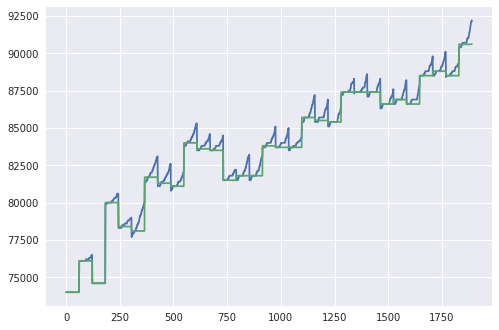

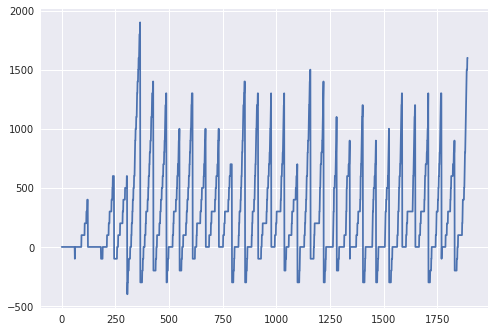

In [13]:
plt.figure()
plt.plot(df_history_ts_process['bid-price'])
plt.plot(df_history_ts_process[col_name_base_price])
plt.plot()
plt.figure()
plt.plot(df_history_ts_process['increment-price'])
plt.plot()

### ['increment-price-target']

In [14]:
# previous N sec ['increment-price-target']

for gap in range(1, 2):
    col_name = 'increment-price-target'
    col_data = pd.DataFrame(columns=[col_name])
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
    #     print('month : ', month)
        for i in range(0, (parm_ts_cycle - parm_calculate_target_second)):
            col_data.loc[month*parm_ts_cycle+i] = df_history_ts_process['increment-price'][month*parm_ts_cycle+i+parm_calculate_target_second]
        for i in range((parm_ts_cycle - parm_calculate_target_second), parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = 0
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data))  

Creating :  increment-price-target
Total records processed :  1891


[]

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


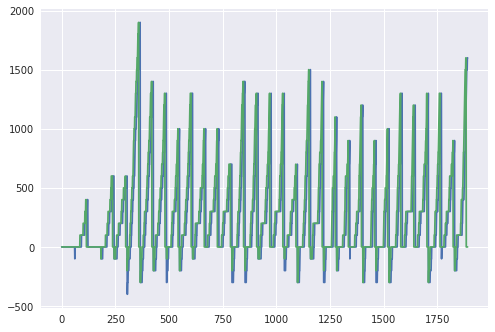

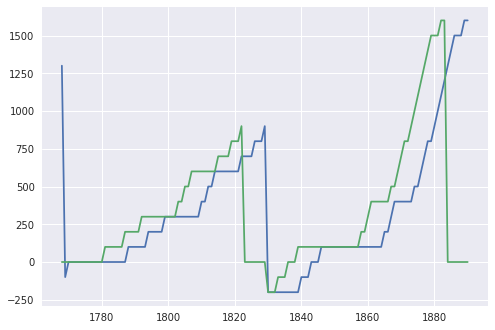

In [15]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'])
plt.plot(df_history_ts_process['increment-price-target'])
plt.plot()

plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price-target'][1768:])
plt.plot()

In [16]:
# previous 'parm_calculate_prev_bp' sec ['increment-price']
gap = parm_calculate_prev_bp

for gap in range(1, gap+1):
    col_name = 'increment-price-prev'+str(gap)+'sec'
    col_data = pd.DataFrame(columns=[col_name])
#     col_data_zeros = pd.DataFrame({col_name: np.zeros(gap)})
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
    #     print('month : ', month)
#         col_data.append(col_data_zeros)
        for i in range(0, gap):
            col_data.loc[month*parm_ts_cycle+i] = 0
        for i in range(gap, parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = df_history_ts_process['increment-price'][month*parm_ts_cycle+i-gap]
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data))  

Creating :  increment-price-prev1sec
Creating :  increment-price-prev2sec
Creating :  increment-price-prev3sec
Creating :  increment-price-prev4sec
Creating :  increment-price-prev5sec
Creating :  increment-price-prev6sec
Creating :  increment-price-prev7sec
Creating :  increment-price-prev8sec
Creating :  increment-price-prev9sec
Creating :  increment-price-prev10sec
Creating :  increment-price-prev11sec
Creating :  increment-price-prev12sec
Creating :  increment-price-prev13sec
Creating :  increment-price-prev14sec
Creating :  increment-price-prev15sec
Total records processed :  1891


In [17]:
# previous 'parm_calculate_mv' sec Moving Average ['increment-price']

gap = parm_calculate_mv

for gap in range(2, gap+1): # MV starts from 2 seconds, till parm_calculate_mv
    col_name = 'increment-price-mv'+str(gap)+'sec'
    col_data = pd.DataFrame(columns=[col_name])
    print('Creating : ', col_name)  

    for month in range(0, parm_ts_month):
    #     print('month : ', month)
        for i in range(0, gap):
            col_data.loc[month*parm_ts_cycle+i] = 0
        for i in range(gap, parm_ts_cycle):
            col_data.loc[month*parm_ts_cycle+i] = \
            np.mean(df_history_ts_process['increment-price'][month*parm_ts_cycle+i-gap:month*parm_ts_cycle+i])
  
    df_history_ts_process[col_name] = col_data

print('Total records processed : ', len(col_data)) 

Creating :  increment-price-mv2sec
Creating :  increment-price-mv3sec
Creating :  increment-price-mv4sec
Creating :  increment-price-mv5sec
Creating :  increment-price-mv6sec
Creating :  increment-price-mv7sec
Creating :  increment-price-mv8sec
Creating :  increment-price-mv9sec
Creating :  increment-price-mv10sec
Creating :  increment-price-mv11sec
Creating :  increment-price-mv12sec
Creating :  increment-price-mv13sec
Creating :  increment-price-mv14sec
Creating :  increment-price-mv15sec
Total records processed :  1891


In [18]:
# df_history_ts_process[1768:]

[]

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


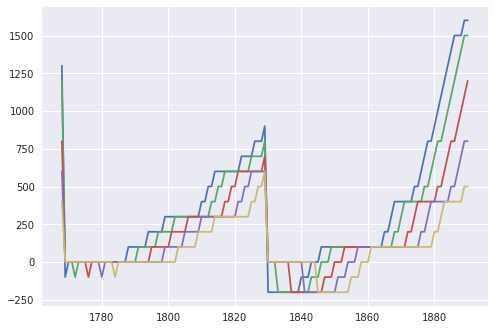

In [19]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price-prev3sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev7sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev11sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev15sec'][1768:])
plt.plot()

[]

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


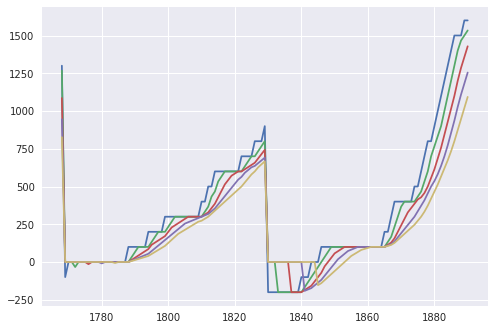

In [20]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price-mv3sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv7sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv11sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv15sec'][1768:])
plt.plot()

### Process: df_history_table_process

In [21]:
df_history_table_process.tail()

,ccyy-mm,volume-plate,deal-price-low,deal-price-avg,deal-early-second,volume-bidder
26,2017-03,10356,87800,87916,55,262010
27,2017-04,12196,89800,89850,59,252273
28,2017-05,10316,90100,90209,55,270197
29,2017-06,10312,89400,89532,45,244349
30,2017-07,10325,92200,92250,57,269189


In [22]:
# date of current month
df_history_table_process['date-curr'] = df_history_table_process.apply(lambda row: pd.to_datetime(row['ccyy-mm']), axis=1)
df_history_table_process['d-avg-low-price'] = df_history_table_process.apply(lambda row: row['deal-price-avg'] - row['deal-price-low'], axis=1)
df_history_table_process['ratio-bid'] = df_history_table_process.apply(lambda row: row['volume-plate'] / row['volume-bidder'], axis=1)

In [23]:
df_history_table_process.tail()

,ccyy-mm,volume-plate,deal-price-low,deal-price-avg,deal-early-second,volume-bidder,date-curr,d-avg-low-price,ratio-bid
26,2017-03,10356,87800,87916,55,262010,2017-03-01,116,0.039525
27,2017-04,12196,89800,89850,59,252273,2017-04-01,50,0.048344
28,2017-05,10316,90100,90209,55,270197,2017-05-01,109,0.038180
29,2017-06,10312,89400,89532,45,244349,2017-06-01,132,0.042202
30,2017-07,10325,92200,92250,57,269189,2017-07-01,50,0.038356


### Merge dataframe

In [24]:
df_history_ts_process_tmp2 = df_history_ts_process.copy()

In [25]:
df_history_ts_process = df_history_ts_process_tmp2.copy()

In [26]:
# look up current month table data: 'volume-plate', 'ratio-bid'
df_history_ts_process = pd.merge(df_history_ts_process, df_history_table_process[['date-curr', 'volume-plate', 'ratio-bid']], how = 'left', left_on = 'date-curr', right_on = 'date-curr', suffixes=['', '_table'])

In [27]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

Index(['ccyy-mm', 'time', 'bid-price', 'date-curr', 'date-prev', 'year',
       'month', 'hour', 'minute', 'second', 'datetime-curr', 'datetime-prev',
       'base-price15sec', 'increment-price', 'increment-price-target',
       'increment-price-prev1sec', 'increment-price-prev2sec',
       'increment-price-prev3sec', 'increment-price-prev4sec',
       'increment-price-prev5sec', 'increment-price-prev6sec',
       'increment-price-prev7sec', 'increment-price-prev8sec',
       'increment-price-prev9sec', 'increment-price-prev10sec',
       'increment-price-prev11sec', 'increment-price-prev12sec',
       'increment-price-prev13sec', 'increment-price-prev14sec',
       'increment-price-prev15sec', 'increment-price-mv2sec',
       'increment-price-mv3sec', 'increment-price-mv4sec',
       'increment-price-mv5sec', 'increment-price-mv6sec',
       'increment-price-mv7sec', 'increment-price-mv8sec',
       'increment-price-mv9sec', 'increment-price-mv10sec',
       'increment-price-mv11sec',

In [28]:
# look up pevious month table data: 'volume-plate', 'ratio-bid', 'deal-early-second', 'deal-price-avg', 'd-avg-low-price'
df_history_ts_process = pd.merge(df_history_ts_process, df_history_table_process[['date-curr', 'volume-plate', 'ratio-bid', 'deal-early-second', 'deal-price-avg', 'd-avg-low-price']], how = 'left', left_on = 'date-prev', right_on = 'date-curr', suffixes=['', '_m0'])

In [29]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

ccyy-mm
time
bid-price
date-curr
date-prev
year
month
hour
minute
second
datetime-curr
datetime-prev
base-price15sec
increment-price
increment-price-target
increment-price-prev1sec
increment-price-prev2sec
increment-price-prev3sec
increment-price-prev4sec
increment-price-prev5sec
increment-price-prev6sec
increment-price-prev7sec
increment-price-prev8sec
increment-price-prev9sec
increment-price-prev10sec
increment-price-prev11sec
increment-price-prev12sec
increment-price-prev13sec
increment-price-prev14sec
increment-price-prev15sec
increment-price-mv2sec
increment-price-mv3sec
increment-price-mv4sec
increment-price-mv5sec
increment-price-mv6sec
increment-price-mv7sec
increment-price-mv8sec
increment-price-mv9sec
increment-price-mv10sec
increment-price-mv11sec
increment-price-mv12sec
increment-price-mv13sec
increment-price-mv14sec
increment-price-mv15sec
volume-plate
ratio-bid
date-curr_m0
volume-plate_m0
ratio-bid_m0
deal-early-second
deal-price-avg
d-avg-low-price


### Shift to copy previous 'parm_calculate_prev_month' month's data into current row

In [30]:
# df_history_ts_process = df_history_ts_process_lookup.copy()

In [31]:
df_history_ts_process_lookup = df_history_ts_process.copy()
df_history_ts_process_lookup.tail()

,ccyy-mm,time,bid-price,date-curr,date-prev,year,month,hour,minute,second,...,increment-price-mv14sec,increment-price-mv15sec,volume-plate,ratio-bid,date-curr_m0,volume-plate_m0,ratio-bid_m0,deal-early-second,deal-price-avg,d-avg-low-price
1886,2017-07,11:29:56,92100,2017-07-01,2017-06-01,2017,07,11,29,56,...,828.571,800,10325,0.038356,2017-06-01,10312.0,0.042202,45.0,89532.0,132.0
1887,2017-07,11:29:57,92100,2017-07-01,2017-06-01,2017,07,11,29,57,...,907.143,873.333,10325,0.038356,2017-06-01,10312.0,0.042202,45.0,89532.0,132.0
1888,2017-07,11:29:58,92100,2017-07-01,2017-06-01,2017,07,11,29,58,...,985.714,946.667,10325,0.038356,2017-06-01,10312.0,0.042202,45.0,89532.0,132.0
1889,2017-07,11:29:59,92200,2017-07-01,2017-06-01,2017,07,11,29,59,...,1057.14,1020,10325,0.038356,2017-06-01,10312.0,0.042202,45.0,89532.0,132.0
1890,2017-07,11:30:00,92200,2017-07-01,2017-06-01,2017,07,11,30,00,...,1135.71,1093.33,10325,0.038356,2017-06-01,10312.0,0.042202,45.0,89532.0,132.0


In [32]:
# _m1
df_history_ts_process = pd.merge(df_history_ts_process, df_history_ts_process_lookup[[ \
        'datetime-curr', 'datetime-prev', 
        'base-price15sec', 'increment-price', 'increment-price-target',
        'increment-price-prev1sec', 'increment-price-prev2sec',
        'increment-price-prev3sec', 'increment-price-prev4sec',
        'increment-price-prev5sec', 'increment-price-prev6sec',
        'increment-price-prev7sec', 'increment-price-prev8sec',
        'increment-price-prev9sec', 'increment-price-prev10sec',
        'increment-price-prev11sec', 'increment-price-prev12sec',
        'increment-price-prev13sec', 'increment-price-prev14sec',
        'increment-price-prev15sec', 
        'increment-price-mv2sec',
        'increment-price-mv3sec', 'increment-price-mv4sec',
        'increment-price-mv5sec', 'increment-price-mv6sec',
        'increment-price-mv7sec', 'increment-price-mv8sec',
        'increment-price-mv9sec', 'increment-price-mv10sec',
        'increment-price-mv11sec', 'increment-price-mv12sec',
        'increment-price-mv13sec', 'increment-price-mv14sec',
        'increment-price-mv15sec', 
        'volume-plate_m0', 
        'ratio-bid_m0', 
        'deal-early-second',
        'deal-price-avg',
        'd-avg-low-price'
        ]], how = 'left', left_on = 'datetime-prev', right_on = 'datetime-curr', suffixes=['', '_m1'])
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,date-curr,date-prev,year,month,hour,minute,second,...,increment-price-mv11sec_m1,increment-price-mv12sec_m1,increment-price-mv13sec_m1,increment-price-mv14sec_m1,increment-price-mv15sec_m1,volume-plate_m0_m1,ratio-bid_m0_m1,deal-early-second_m1,deal-price-avg_m1,d-avg-low-price_m1
1886,2017-07,11:29:56,92100,2017-07-01,2017-06-01,2017,07,11,29,56,...,627.273,616.667,607.692,592.857,580,10316.0,0.03818,55.0,90209.0,109.0
1887,2017-07,11:29:57,92100,2017-07-01,2017-06-01,2017,07,11,29,57,...,636.364,633.333,623.077,614.286,600,10316.0,0.03818,55.0,90209.0,109.0
1888,2017-07,11:29:58,92100,2017-07-01,2017-06-01,2017,07,11,29,58,...,654.545,650,646.154,635.714,626.667,10316.0,0.03818,55.0,90209.0,109.0
1889,2017-07,11:29:59,92200,2017-07-01,2017-06-01,2017,07,11,29,59,...,672.727,666.667,661.538,657.143,646.667,10316.0,0.03818,55.0,90209.0,109.0
1890,2017-07,11:30:00,92200,2017-07-01,2017-06-01,2017,07,11,30,00,...,690.909,683.333,676.923,671.429,666.667,10316.0,0.03818,55.0,90209.0,109.0


In [33]:
# _m2
df_history_ts_process = pd.merge(df_history_ts_process, df_history_ts_process_lookup[[ \
        'datetime-curr', 'datetime-prev', 
        'base-price15sec', 'increment-price', 'increment-price-target',
        'increment-price-prev1sec', 'increment-price-prev2sec',
        'increment-price-prev3sec', 'increment-price-prev4sec',
        'increment-price-prev5sec', 'increment-price-prev6sec',
        'increment-price-prev7sec', 'increment-price-prev8sec',
        'increment-price-prev9sec', 'increment-price-prev10sec',
        'increment-price-prev11sec', 'increment-price-prev12sec',
        'increment-price-prev13sec', 'increment-price-prev14sec',
        'increment-price-prev15sec', 
        'increment-price-mv2sec',
        'increment-price-mv3sec', 'increment-price-mv4sec',
        'increment-price-mv5sec', 'increment-price-mv6sec',
        'increment-price-mv7sec', 'increment-price-mv8sec',
        'increment-price-mv9sec', 'increment-price-mv10sec',
        'increment-price-mv11sec', 'increment-price-mv12sec',
        'increment-price-mv13sec', 'increment-price-mv14sec',
        'increment-price-mv15sec', 
        'volume-plate_m0', 
        'ratio-bid_m0', 
        'deal-early-second',
        'deal-price-avg',
        'd-avg-low-price'                                                                                   
        ]], how = 'left', left_on = 'datetime-prev_m1', right_on = 'datetime-curr', suffixes=['', '_m2'])
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,date-curr,date-prev,year,month,hour,minute,second,...,increment-price-mv11sec_m2,increment-price-mv12sec_m2,increment-price-mv13sec_m2,increment-price-mv14sec_m2,increment-price-mv15sec_m2,volume-plate_m0_m2,ratio-bid_m0_m2,deal-early-second_m2,deal-price-avg_m2,d-avg-low-price_m2
1886,2017-07,11:29:56,92100,2017-07-01,2017-06-01,2017,07,11,29,56,...,681.818,658.333,630.769,607.143,586.667,12196.0,0.048344,59.0,89850.0,50.0
1887,2017-07,11:29:57,92100,2017-07-01,2017-06-01,2017,07,11,29,57,...,745.455,716.667,692.308,664.286,640,12196.0,0.048344,59.0,89850.0,50.0
1888,2017-07,11:29:58,92100,2017-07-01,2017-06-01,2017,07,11,29,58,...,809.091,783.333,753.846,728.571,700,12196.0,0.048344,59.0,89850.0,50.0
1889,2017-07,11:29:59,92200,2017-07-01,2017-06-01,2017,07,11,29,59,...,881.818,850,823.077,792.857,766.667,12196.0,0.048344,59.0,89850.0,50.0
1890,2017-07,11:30:00,92200,2017-07-01,2017-06-01,2017,07,11,30,00,...,945.455,916.667,884.615,857.143,826.667,12196.0,0.048344,59.0,89850.0,50.0


In [34]:
# _m3
df_history_ts_process = pd.merge(df_history_ts_process, df_history_ts_process_lookup[[ \
        'datetime-curr', 'datetime-prev', 
        'base-price15sec', 'increment-price', 'increment-price-target',
        'increment-price-prev1sec', 'increment-price-prev2sec',
        'increment-price-prev3sec', 'increment-price-prev4sec',
        'increment-price-prev5sec', 'increment-price-prev6sec',
        'increment-price-prev7sec', 'increment-price-prev8sec',
        'increment-price-prev9sec', 'increment-price-prev10sec',
        'increment-price-prev11sec', 'increment-price-prev12sec',
        'increment-price-prev13sec', 'increment-price-prev14sec',
        'increment-price-prev15sec', 
        'increment-price-mv2sec',
        'increment-price-mv3sec', 'increment-price-mv4sec',
        'increment-price-mv5sec', 'increment-price-mv6sec',
        'increment-price-mv7sec', 'increment-price-mv8sec',
        'increment-price-mv9sec', 'increment-price-mv10sec',
        'increment-price-mv11sec', 'increment-price-mv12sec',
        'increment-price-mv13sec', 'increment-price-mv14sec',
        'increment-price-mv15sec', 
        'volume-plate_m0', 
        'ratio-bid_m0', 
        'deal-early-second',
        'deal-price-avg',
        'd-avg-low-price'                                                                                  
        ]], how = 'left', left_on = 'datetime-prev_m2', right_on = 'datetime-curr', suffixes=['', '_m3'])
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,date-curr,date-prev,year,month,hour,minute,second,...,increment-price-mv11sec_m3,increment-price-mv12sec_m3,increment-price-mv13sec_m3,increment-price-mv14sec_m3,increment-price-mv15sec_m3,volume-plate_m0_m3,ratio-bid_m0_m3,deal-early-second_m3,deal-price-avg_m3,d-avg-low-price_m3
1886,2017-07,11:29:56,92100,2017-07-01,2017-06-01,2017,07,11,29,56,...,709.091,691.667,669.231,650,626.667,10356.0,0.039525,55.0,87916.0,116.0
1887,2017-07,11:29:57,92100,2017-07-01,2017-06-01,2017,07,11,29,57,...,736.364,725,707.692,685.714,666.667,10356.0,0.039525,55.0,87916.0,116.0
1888,2017-07,11:29:58,92100,2017-07-01,2017-06-01,2017,07,11,29,58,...,772.727,758.333,746.154,728.571,706.667,10356.0,0.039525,55.0,87916.0,116.0
1889,2017-07,11:29:59,92200,2017-07-01,2017-06-01,2017,07,11,29,59,...,809.091,791.667,776.923,764.286,746.667,10356.0,0.039525,55.0,87916.0,116.0
1890,2017-07,11:30:00,92200,2017-07-01,2017-06-01,2017,07,11,30,00,...,845.455,833.333,815.385,800,786.667,10356.0,0.039525,55.0,87916.0,116.0


[]

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


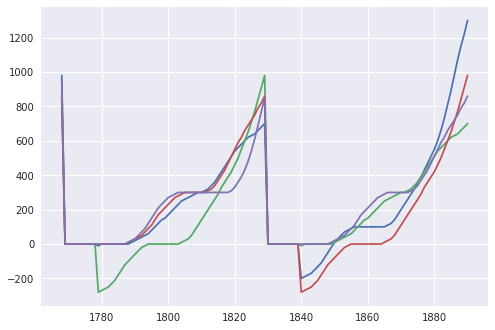

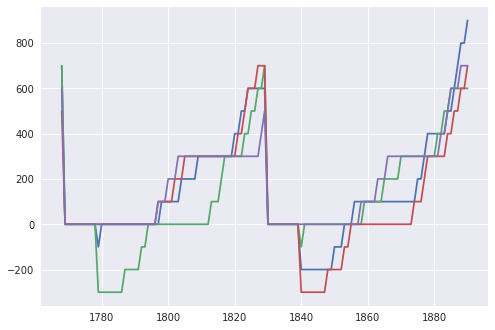

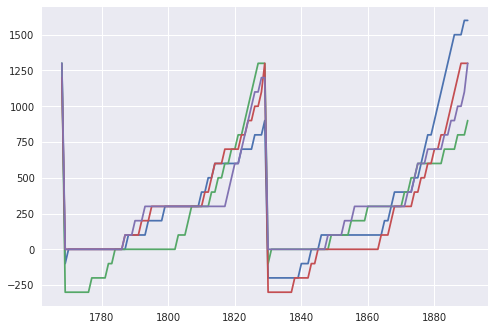

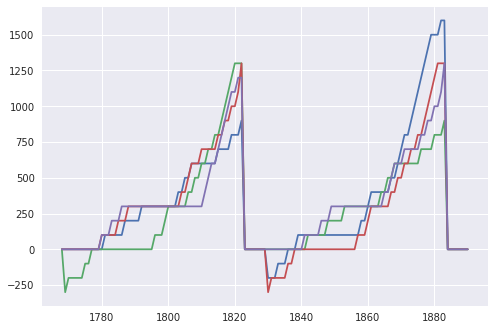

In [35]:
plt.figure()
plt.plot(df_history_ts_process['increment-price-mv10sec'][1768:])
plt.plot(df_history_ts_process['increment-price-mv10sec_m1'][1768:])
plt.plot(df_history_ts_process['increment-price-mv10sec_m2'][1768:])
plt.plot(df_history_ts_process['increment-price-mv10sec_m3'][1768:])
plt.figure()
plt.plot(df_history_ts_process['increment-price-prev10sec'][1768:])
plt.plot(df_history_ts_process['increment-price-prev10sec_m1'][1768:])
plt.plot(df_history_ts_process['increment-price-prev10sec_m2'][1768:])
plt.plot(df_history_ts_process['increment-price-prev10sec_m3'][1768:])
plt.figure()
plt.plot(df_history_ts_process['increment-price'][1768:])
plt.plot(df_history_ts_process['increment-price_m1'][1768:])
plt.plot(df_history_ts_process['increment-price_m2'][1768:])
plt.plot(df_history_ts_process['increment-price_m3'][1768:])
plt.figure()
plt.plot(df_history_ts_process['increment-price-target'][1768:])
plt.plot(df_history_ts_process['increment-price-target_m1'][1768:])
plt.plot(df_history_ts_process['increment-price-target_m2'][1768:])
plt.plot(df_history_ts_process['increment-price-target_m3'][1768:])

plt.plot()

### Housekeeping to remove some invald data during pre-processing

In [36]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

ccyy-mm
time
bid-price
date-curr
date-prev
year
month
hour
minute
second
datetime-curr
datetime-prev
base-price15sec
increment-price
increment-price-target
increment-price-prev1sec
increment-price-prev2sec
increment-price-prev3sec
increment-price-prev4sec
increment-price-prev5sec
increment-price-prev6sec
increment-price-prev7sec
increment-price-prev8sec
increment-price-prev9sec
increment-price-prev10sec
increment-price-prev11sec
increment-price-prev12sec
increment-price-prev13sec
increment-price-prev14sec
increment-price-prev15sec
increment-price-mv2sec
increment-price-mv3sec
increment-price-mv4sec
increment-price-mv5sec
increment-price-mv6sec
increment-price-mv7sec
increment-price-mv8sec
increment-price-mv9sec
increment-price-mv10sec
increment-price-mv11sec
increment-price-mv12sec
increment-price-mv13sec
increment-price-mv14sec
increment-price-mv15sec
volume-plate
ratio-bid
date-curr_m0
volume-plate_m0
ratio-bid_m0
deal-early-second
deal-price-avg
d-avg-low-price
datetime-curr_m1
date

In [ ]:
# housekeeping: delete some columns
# df_history_ts_process.drop('date-curr_y', axis=1, inplace=True)

In [37]:
parm_record_cut_ccyy

Timestamp('2015-04-01 00:00:00')

In [38]:
# remove first 'parm_record_cut_ccyy' months from dataset
df_history_ts_process = df_history_ts_process[df_history_ts_process['date-curr'] > parm_record_cut_ccyy]

In [39]:
# total 61 seconds/rows per month:
# remove first 'parm_record_cut_row_head' reconds
# remove last 'parm_record_cut_row_tail' reconds
df_history_ts_process = df_history_ts_process[df_history_ts_process['second'] >= str(parm_record_cut_row_head) ]
df_history_ts_process = df_history_ts_process[df_history_ts_process['second'] <= str(60 - parm_record_cut_row_tail) ]
# df_history_ts_process = df_history_ts_process[df_history_ts_process['second'] > parm_record_cut_row_head ]

In [40]:
# Reset index after housekeeping
df_history_ts_process = df_history_ts_process.reset_index(drop=True)

In [41]:
df_history_ts_process.head()

,ccyy-mm,time,bid-price,date-curr,date-prev,year,month,hour,minute,second,...,increment-price-mv11sec_m3,increment-price-mv12sec_m3,increment-price-mv13sec_m3,increment-price-mv14sec_m3,increment-price-mv15sec_m3,volume-plate_m0_m3,ratio-bid_m0_m3,deal-early-second_m3,deal-price-avg_m3,d-avg-low-price_m3
0,2015-05,11:29:15,78400,2015-05-01,2015-04-01,2015,05,11,29,15,...,0,0,0,0,-6.66667,7990.0,0.081362,48.0,74216.0,216.0
1,2015-05,11:29:16,78400,2015-05-01,2015-04-01,2015,05,11,29,16,...,0,0,0,0,0,7990.0,0.081362,48.0,74216.0,216.0
2,2015-05,11:29:17,78400,2015-05-01,2015-04-01,2015,05,11,29,17,...,0,0,0,0,0,7990.0,0.081362,48.0,74216.0,216.0
3,2015-05,11:29:18,78400,2015-05-01,2015-04-01,2015,05,11,29,18,...,0,0,0,0,0,7990.0,0.081362,48.0,74216.0,216.0
4,2015-05,11:29:19,78500,2015-05-01,2015-04-01,2015,05,11,29,19,...,0,0,0,0,0,7990.0,0.081362,48.0,74216.0,216.0


In [42]:
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,date-curr,date-prev,year,month,hour,minute,second,...,increment-price-mv11sec_m3,increment-price-mv12sec_m3,increment-price-mv13sec_m3,increment-price-mv14sec_m3,increment-price-mv15sec_m3,volume-plate_m0_m3,ratio-bid_m0_m3,deal-early-second_m3,deal-price-avg_m3,d-avg-low-price_m3
1048,2017-07,11:29:49,91400,2017-07-01,2017-06-01,2017,07,11,29,49,...,454.545,441.667,430.769,421.429,413.333,10356.0,0.039525,55.0,87916.0,116.0
1049,2017-07,11:29:50,91500,2017-07-01,2017-06-01,2017,07,11,29,50,...,490.909,475,461.538,450,440,10356.0,0.039525,55.0,87916.0,116.0
1050,2017-07,11:29:51,91600,2017-07-01,2017-06-01,2017,07,11,29,51,...,527.273,508.333,492.308,478.571,466.667,10356.0,0.039525,55.0,87916.0,116.0
1051,2017-07,11:29:52,91700,2017-07-01,2017-06-01,2017,07,11,29,52,...,563.636,541.667,523.077,507.143,493.333,10356.0,0.039525,55.0,87916.0,116.0
1052,2017-07,11:29:53,91800,2017-07-01,2017-06-01,2017,07,11,29,53,...,600,575,553.846,535.714,520,10356.0,0.039525,55.0,87916.0,116.0


[]

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


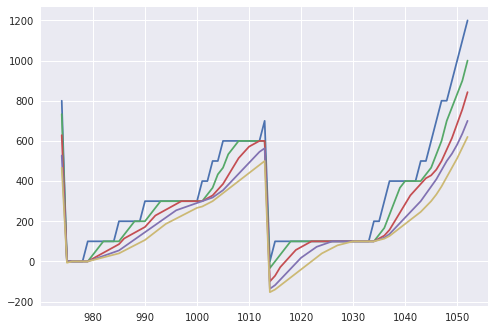

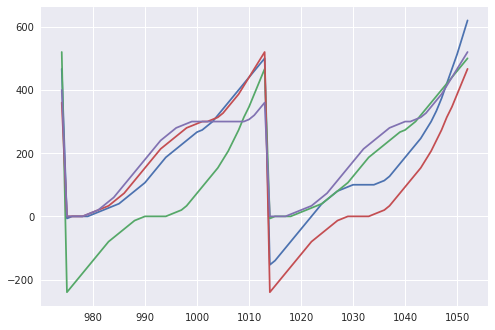

In [43]:
plt.figure()
plt.plot(df_history_ts_process['increment-price'][974:])
plt.plot(df_history_ts_process['increment-price-mv3sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv7sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv11sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec'][974:])
plt.figure()
plt.plot(df_history_ts_process['increment-price-mv15sec'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec_m1'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec_m2'][974:])
plt.plot(df_history_ts_process['increment-price-mv15sec_m3'][974:])
plt.plot()

# [3] Modeling Part 2: Python scikit-learn

### Models to use:

* GradientBoostingClassifier
* RandomForestClassifier
* AdaBoostClassifier
* ExtraTreesClassifier
* BaggingClassifier
* LogisticRegression
* SVM kernal RBF
* SVM kernal Linear
* KNeighborsClassifier


### Import pre-processed data

In [99]:
df_history_ts_process = pd.read_csv('bid_v007_ReScale.csv') 
df_history_ts_process.tail()

,target.7sec,ccyyy.mm.curr,ccyyy.mm.prev,bid.time,bid.sec,month,bid.curr.mth,increment.curr.mth,MV.3sec.curr,MV.5sec.curr,...,R01_Volume.Bidder.curr.mth,R01_success.ratio.curr.mth,R01_Volume.Plate.prev.mth,R01_Volume.Bidder.prev.mth,R01_success.ratio.prev.mth,R01_d.Volume.Plate,R01_d.Volume.Bidder,R01_d.success.ratio,R01_anomaly,R01_target.7sec
356,1300,2017-07,2017-06,11:29:49,49,7,91400,600,500.000000,420.0,...,0.903714,0.041615,0.503564,0.660375,0.248754,0.371347,0.844656,0.37555,1.0,0.928571
357,1300,2017-07,2017-06,11:29:50,50,7,91500,700,566.666667,480.0,...,0.903714,0.041615,0.503564,0.660375,0.248754,0.371347,0.844656,0.37555,1.0,0.928571
358,1300,2017-07,2017-06,11:29:51,51,7,91600,800,633.333333,560.0,...,0.903714,0.041615,0.503564,0.660375,0.248754,0.371347,0.844656,0.37555,1.0,0.928571
359,1400,2017-07,2017-06,11:29:52,52,7,91700,900,700.000000,640.0,...,0.903714,0.041615,0.503564,0.660375,0.248754,0.371347,0.844656,0.37555,1.0,1.000000
360,1400,2017-07,2017-06,11:29:53,53,7,91800,1000,800.000000,720.0,...,0.903714,0.041615,0.503564,0.660375,0.248754,0.371347,0.844656,0.37555,1.0,1.000000


In [100]:
for i in range(0, len(df_history_ts_process.columns)): print(df_history_ts_process.columns[i])

target.7sec
ccyyy.mm.curr
ccyyy.mm.prev
bid.time
bid.sec
month
bid.curr.mth
increment.curr.mth
MV.3sec.curr
MV.5sec.curr
MV.3sec.curr.d.Avg.Low.prev.mth
MV.5sec.curr.d.Avg.Low.prev.mth
bid.prev.mth
increment.prev.mth
MV.3sec.prev
MV.5sec.prev
MV.3sec.prev.d.Avg.Low.prev.mth
MV.5sec.prev.d.Avg.Low.prev.mth
d.Avg.Low.prev.mth
increment.curr.mth.d.Avg.Low.prev.mth
d.earliest.success.time.sec.prev.mth
Volume.Plate.curr.mth
Volume.Bidder.curr.mth
success.ratio.curr.mth
Volume.Plate.prev.mth
Volume.Bidder.prev.mth
success.ratio.prev.mth
d.Volume.Plate
d.Volume.Bidder
d.success.ratio
anomaly
R01_bid.sec
R01_month
R01_bid.curr.mth
R01_increment.curr.mth
R01_MV.3sec.curr
R01_MV.5sec.curr
R01_MV.3sec.curr.d.Avg.Low.prev.mth
R01_MV.5sec.curr.d.Avg.Low.prev.mth
R01_bid.prev.mth
R01_increment.prev.mth
R01_MV.3sec.prev
R01_MV.5sec.prev
R01_MV.3sec.prev.d.Avg.Low.prev.mth
R01_MV.5sec.prev.d.Avg.Low.prev.mth
R01_d.Avg.Low.prev.mth
R01_increment.curr.mth.d.Avg.Low.prev.mth
R01_d.earliest.success.time.s

In [69]:
X = df_history_ts_process[[
#          ,'ccyy-mm'
#         ,'time'
#         ,'bid-price'
#         ,'date-curr'
#         ,'date-prev'
#         ,'year'
         'month'
#         ,'hour'
#         ,'minute'
        ,'second'
#         ,'datetime-curr'
#         ,'datetime-prev'
        ,'base-price15sec'
        ,'increment-price'
#         ,'increment-price-target'   # <<<<<<< This is target 
        ,'increment-price-prev1sec'
        ,'increment-price-prev2sec'
        ,'increment-price-prev3sec'
        ,'increment-price-prev4sec'
        ,'increment-price-prev5sec'
        ,'increment-price-prev6sec'
        ,'increment-price-prev7sec'
        ,'increment-price-prev8sec'
        ,'increment-price-prev9sec'
        ,'increment-price-prev10sec'
        ,'increment-price-prev11sec'
        ,'increment-price-prev12sec'
        ,'increment-price-prev13sec'
        ,'increment-price-prev14sec'
        ,'increment-price-prev15sec'
        ,'increment-price-mv2sec'
        ,'increment-price-mv3sec'
        ,'increment-price-mv4sec'
        ,'increment-price-mv5sec'
        ,'increment-price-mv6sec'
        ,'increment-price-mv7sec'
        ,'increment-price-mv8sec'
        ,'increment-price-mv9sec'
        ,'increment-price-mv10sec'
        ,'increment-price-mv11sec'
        ,'increment-price-mv12sec'
        ,'increment-price-mv13sec'
        ,'increment-price-mv14sec'
        ,'increment-price-mv15sec'
        ,'volume-plate'
        ,'ratio-bid'
#         ,'date-curr_m0'
        ,'volume-plate_m0'
        ,'ratio-bid_m0'
        ,'deal-early-second'
        ,'deal-price-avg'
        ,'d-avg-low-price'
    
#         ,'datetime-curr_m1'
#         ,'datetime-prev_m1'
        ,'base-price15sec_m1'
        ,'increment-price_m1'
        ,'increment-price-target_m1'
        ,'increment-price-prev1sec_m1'
        ,'increment-price-prev2sec_m1'
        ,'increment-price-prev3sec_m1'
        ,'increment-price-prev4sec_m1'
        ,'increment-price-prev5sec_m1'
        ,'increment-price-prev6sec_m1'
        ,'increment-price-prev7sec_m1'
        ,'increment-price-prev8sec_m1'
        ,'increment-price-prev9sec_m1'
        ,'increment-price-prev10sec_m1'
        ,'increment-price-prev11sec_m1'
        ,'increment-price-prev12sec_m1'
        ,'increment-price-prev13sec_m1'
        ,'increment-price-prev14sec_m1'
        ,'increment-price-prev15sec_m1'
        ,'increment-price-mv2sec_m1'
        ,'increment-price-mv3sec_m1'
        ,'increment-price-mv4sec_m1'
        ,'increment-price-mv5sec_m1'
        ,'increment-price-mv6sec_m1'
        ,'increment-price-mv7sec_m1'
        ,'increment-price-mv8sec_m1'
        ,'increment-price-mv9sec_m1'
        ,'increment-price-mv10sec_m1'
        ,'increment-price-mv11sec_m1'
        ,'increment-price-mv12sec_m1'
        ,'increment-price-mv13sec_m1'
        ,'increment-price-mv14sec_m1'
        ,'increment-price-mv15sec_m1'
        ,'volume-plate_m0_m1'
        ,'ratio-bid_m0_m1'
        ,'deal-early-second_m1'
        ,'deal-price-avg_m1'
        ,'d-avg-low-price_m1'
    
#         ,'datetime-curr_m2'
#         ,'datetime-prev_m2'
        ,'base-price15sec_m2'
        ,'increment-price_m2'
        ,'increment-price-target_m2'
        ,'increment-price-prev1sec_m2'
        ,'increment-price-prev2sec_m2'
        ,'increment-price-prev3sec_m2'
        ,'increment-price-prev4sec_m2'
        ,'increment-price-prev5sec_m2'
        ,'increment-price-prev6sec_m2'
        ,'increment-price-prev7sec_m2'
        ,'increment-price-prev8sec_m2'
        ,'increment-price-prev9sec_m2'
        ,'increment-price-prev10sec_m2'
        ,'increment-price-prev11sec_m2'
        ,'increment-price-prev12sec_m2'
        ,'increment-price-prev13sec_m2'
        ,'increment-price-prev14sec_m2'
        ,'increment-price-prev15sec_m2'
        ,'increment-price-mv2sec_m2'
        ,'increment-price-mv3sec_m2'
        ,'increment-price-mv4sec_m2'
        ,'increment-price-mv5sec_m2'
        ,'increment-price-mv6sec_m2'
        ,'increment-price-mv7sec_m2'
        ,'increment-price-mv8sec_m2'
        ,'increment-price-mv9sec_m2'
        ,'increment-price-mv10sec_m2'
        ,'increment-price-mv11sec_m2'
        ,'increment-price-mv12sec_m2'
        ,'increment-price-mv13sec_m2'
        ,'increment-price-mv14sec_m2'
        ,'increment-price-mv15sec_m2'
        ,'volume-plate_m0_m2'
        ,'ratio-bid_m0_m2'
        ,'deal-early-second_m2'
        ,'deal-price-avg_m2'
        ,'d-avg-low-price_m2'
    
#         ,'datetime-curr_m3'
#         ,'datetime-prev_m3'
        ,'base-price15sec_m3'
        ,'increment-price_m3'
        ,'increment-price-target_m3'
        ,'increment-price-prev1sec_m3'
        ,'increment-price-prev2sec_m3'
        ,'increment-price-prev3sec_m3'
        ,'increment-price-prev4sec_m3'
        ,'increment-price-prev5sec_m3'
        ,'increment-price-prev6sec_m3'
        ,'increment-price-prev7sec_m3'
        ,'increment-price-prev8sec_m3'
        ,'increment-price-prev9sec_m3'
        ,'increment-price-prev10sec_m3'
        ,'increment-price-prev11sec_m3'
        ,'increment-price-prev12sec_m3'
        ,'increment-price-prev13sec_m3'
        ,'increment-price-prev14sec_m3'
        ,'increment-price-prev15sec_m3'
        ,'increment-price-mv2sec_m3'
        ,'increment-price-mv3sec_m3'
        ,'increment-price-mv4sec_m3'
        ,'increment-price-mv5sec_m3'
        ,'increment-price-mv6sec_m3'
        ,'increment-price-mv7sec_m3'
        ,'increment-price-mv8sec_m3'
        ,'increment-price-mv9sec_m3'
        ,'increment-price-mv10sec_m3'
        ,'increment-price-mv11sec_m3'
        ,'increment-price-mv12sec_m3'
        ,'increment-price-mv13sec_m3'
        ,'increment-price-mv14sec_m3'
        ,'increment-price-mv15sec_m3'
        ,'volume-plate_m0_m3'
        ,'ratio-bid_m0_m3'
        ,'deal-early-second_m3'
        ,'deal-price-avg_m3'
        ,'d-avg-low-price_m3'
        ]]

X_col = X.columns # get the column list

# X = StandardScaler().fit_transform(X.as_matrix())
X = X.as_matrix()

# y = StandardScaler().fit_transform(df_wnv_raw[['increment-price-target']].as_matrix()).reshape(len(df_wnv_raw),)
y = df_history_ts_process[['increment-price-target']].as_matrix().reshape(len(df_history_ts_process),)


In [118]:
df_history_ts_process.head(20)

,target.7sec,ccyyy.mm.curr,ccyyy.mm.prev,bid.time,bid.sec,month,bid.curr.mth,increment.curr.mth,MV.3sec.curr,MV.5sec.curr,...,R01_Volume.Bidder.curr.mth,R01_success.ratio.curr.mth,R01_Volume.Plate.prev.mth,R01_Volume.Bidder.prev.mth,R01_success.ratio.prev.mth,R01_d.Volume.Plate,R01_d.Volume.Bidder,R01_d.success.ratio,R01_anomaly,R01_target.7sec
0,0,2016-01,2015-12,11:29:35,35,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.000000
1,0,2016-01,2015-12,11:29:36,36,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.000000
2,100,2016-01,2015-12,11:29:37,37,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.071429
3,100,2016-01,2015-12,11:29:38,38,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.071429
4,100,2016-01,2015-12,11:29:39,39,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.071429
5,200,2016-01,2015-12,11:29:40,40,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.142857
6,200,2016-01,2015-12,11:29:41,41,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.142857
7,200,2016-01,2015-12,11:29:42,42,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.142857
8,300,2016-01,2015-12,11:29:43,43,1,81800,0,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.214286
9,300,2016-01,2015-12,11:29:44,44,1,81900,100,0.000000,0.0,...,0.000000,0.678037,0.000000,0.000000,0.290318,0.675811,0.611385,0.867524,0.0,0.214286


In [103]:
X = df_history_ts_process[[
#         ,'target.7sec'
#         ,'ccyyy.mm.curr'
#         ,'ccyyy.mm.prev'
#         ,'bid.time'
         'bid.sec'
        ,'month'
        ,'bid.curr.mth'
        ,'increment.curr.mth'
        ,'MV.3sec.curr'
        ,'MV.5sec.curr'
        ,'MV.3sec.curr.d.Avg.Low.prev.mth'
        ,'MV.5sec.curr.d.Avg.Low.prev.mth'
        ,'bid.prev.mth'
        ,'increment.prev.mth'
        ,'MV.3sec.prev'
        ,'MV.5sec.prev'
        ,'MV.3sec.prev.d.Avg.Low.prev.mth'
        ,'MV.5sec.prev.d.Avg.Low.prev.mth'
        ,'d.Avg.Low.prev.mth'
        ,'increment.curr.mth.d.Avg.Low.prev.mth'
        ,'d.earliest.success.time.sec.prev.mth'
        ,'Volume.Plate.curr.mth'
        ,'Volume.Bidder.curr.mth'
        ,'success.ratio.curr.mth'
        ,'Volume.Plate.prev.mth'
        ,'Volume.Bidder.prev.mth'
        ,'success.ratio.prev.mth'
        ,'d.Volume.Plate'
        ,'d.Volume.Bidder'
        ,'d.success.ratio'
#         ,'anomaly'
    
        ]]

X_col = X.columns # get the column list

# X = StandardScaler().fit_transform(X.as_matrix())
X = X.as_matrix()

# y = StandardScaler().fit_transform(df_history_ts_process[['increment-price-target']].as_matrix()).reshape(len(df_wnv_raw),)
y = df_history_ts_process[['target.7sec']].as_matrix().reshape(len(df_history_ts_process),)


In [104]:
X_col

Index(['bid.sec', 'month', 'bid.curr.mth', 'increment.curr.mth',
       'MV.3sec.curr', 'MV.5sec.curr', 'MV.3sec.curr.d.Avg.Low.prev.mth',
       'MV.5sec.curr.d.Avg.Low.prev.mth', 'bid.prev.mth', 'increment.prev.mth',
       'MV.3sec.prev', 'MV.5sec.prev', 'MV.3sec.prev.d.Avg.Low.prev.mth',
       'MV.5sec.prev.d.Avg.Low.prev.mth', 'd.Avg.Low.prev.mth',
       'increment.curr.mth.d.Avg.Low.prev.mth',
       'd.earliest.success.time.sec.prev.mth', 'Volume.Plate.curr.mth',
       'Volume.Bidder.curr.mth', 'success.ratio.curr.mth',
       'Volume.Plate.prev.mth', 'Volume.Bidder.prev.mth',
       'success.ratio.prev.mth', 'd.Volume.Plate', 'd.Volume.Bidder',
       'd.success.ratio'],
      dtype='object')

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


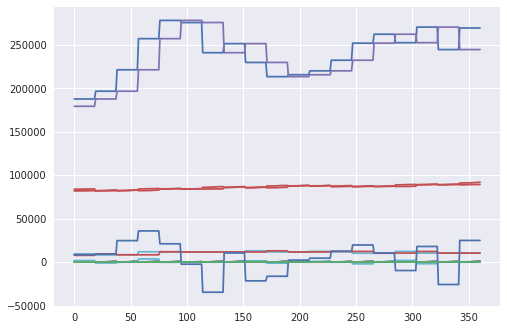

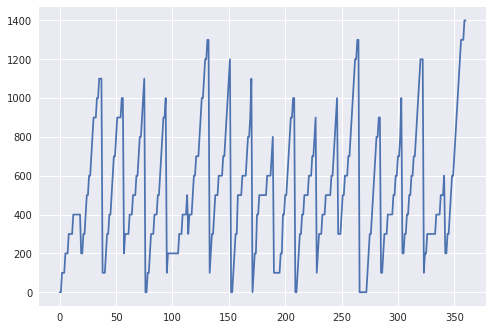

In [105]:
plt.figure()
plt.plot(X)
plt.figure()
plt.plot(y)


# [4] Evaluation
### K-fold Cross-Validation

In [106]:
rng = check_random_state(0)

In [107]:
# GB
classifier_GB = GradientBoostingRegressor(n_estimators=1500, # score: 0.94608 (AUC 0.81419), learning_rate=0.001, max_features=8 <<< Best
#                                    loss='deviance',
#                                    subsample=1,
#                                    max_depth=5,
#                                    min_samples_split=20,
                                   learning_rate=0.002,
#                                    max_features=10,
                                   random_state=rng)

In [108]:
# AB
classifier_AB = AdaBoostRegressor(n_estimators=1500, # score: 0.93948 (AUC 0.88339), learning_rate=0.004 <<< Best
                                   learning_rate=0.002,
                                   random_state=rng)

In [109]:
# RF
classifier_RF = RandomForestRegressor(n_estimators=1500, # score: 0.94207 (AUC 0.81870), max_depth=3, min_samples_split=20, <<< Best
#                                     max_features=10,
#                                     max_depth=3,
#                                     min_samples_split=20,
                                    random_state=rng)

In [110]:
# ET
classifier_ET = ExtraTreesRegressor(n_estimators=1000, # score: 0.94655 (AUC 0.84364), max_depth=3, min_samples_split=20, max_features=10 <<< Best
#                                     max_depth=3,
#                                     min_samples_split=20,
#                                     max_features=10,
                                    random_state=rng)

In [111]:
# BG
classifier_BG = BaggingRegressor(n_estimators=500, # score: 0.70725 (AUC 0.63729) <<< Best
#                                     max_features=10,
                                    random_state=rng)

### LR

In [112]:
classifier_LR = LinearRegression() # score: 0.90199 (AUC 0.80569)

### SVM Linear

In [113]:
# classifier_SVCL = svm.SVC(kernel='linear', probability=True, random_state=rng) # score: 0.89976 (AUC 0.70524)
classifier_SVRL = svm.SVR() # score: 0.89976 (AUC 0.70524)

### SVM

In [114]:
classifier_SVRR = svm.SVR(kernel='rbf') # score: 0.80188 (AUC 0.50050)
# classifier_SVRR = svm.SVR(kernel='poly') # score: 0.80188 (AUC 0.50050)

### KNN

In [115]:
classifier_KNN = KNeighborsRegressor(n_neighbors=2) # score: 0.94018 (AUC 0.72792)
cv = cross_val_score(classifier_KNN,
                            X,
                            y,
                            cv=StratifiedKFold(parm_ts_valid_month))
print('KNN CV score: {0:.5f}'.format(cv.mean()))

KNN CV score: 0.92711


/home/user/env_py3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=27.
  % (min_groups, self.n_splits)), Warning)


### Select Model

In [157]:
classifier = classifier_GB   # 324.632308296
# classifier = classifier_AB   # 429.646733221
# classifier = classifier_RF   # 175.504322802
# classifier = classifier_ET   # 172.097916817, 0.0724812030075
# classifier = classifier_BG   # 175.451381872
# classifier = classifier_LR     # 128.465059749, 0.11
# classifier = classifier_SVRL # 3789.82169312
# classifier = classifier_SVRR # 3789.82169312, 0.10754224349

### Split Data

In [158]:
n_splits = parm_ts_valid_cycle
print('cycle seconds : %d' % n_splits)
# n_splits=54 # 19 seconds/records for each bidding month
# n_splits=19 # 19 seconds/records for each bidding month
n_fold = parm_ts_valid_month
print('cycle month   : %d' % n_fold)


# X_train_1 = X[0:(len(X)-batch*n_splits)]
# y_train_1 = y[0:(len(X)-batch*n_splits)]

# X_test_1 = X[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]
# y_test_1 = y[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]


cycle seconds : 39
cycle month   : 27


### CV

In [159]:
n_splits=19
n_fold=5

342


/home/user/env_py3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/user/env_py3/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


323
304
285


/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


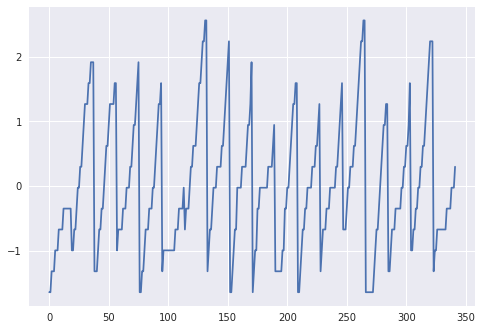

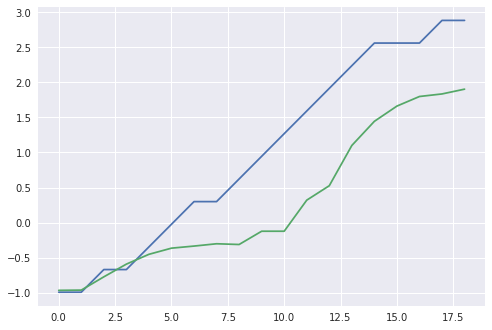

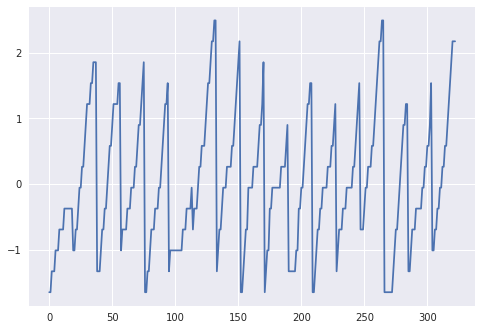

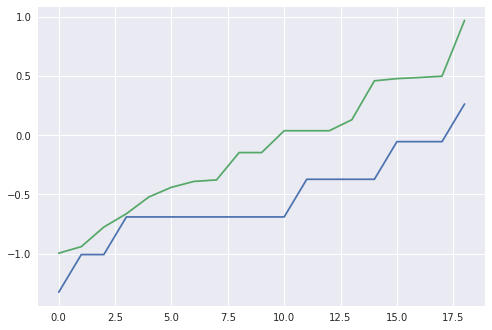

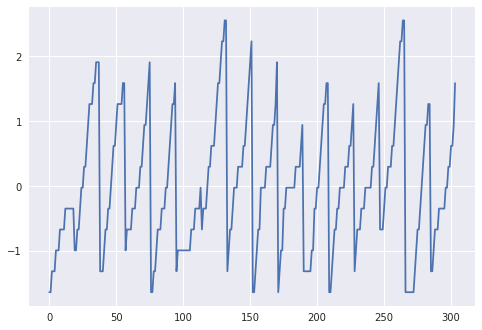

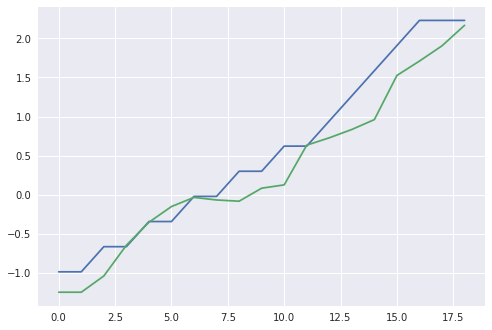

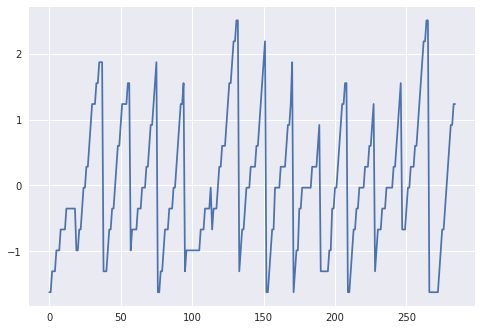

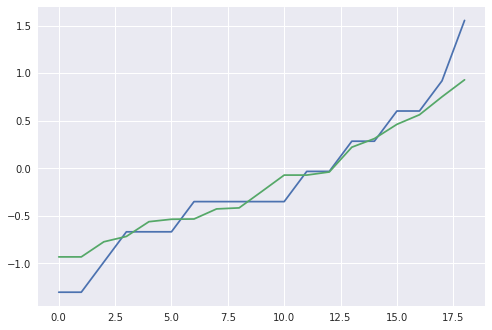

In [160]:
y_pred = {}
y_test = {}

y_pred_org = {}
y_test_org = {}

i = 0
for batch in range(1, n_fold):
    X_train_1 = X[0:(len(X)-batch*n_splits)]
    y_train_1 = y[0:(len(X)-batch*n_splits)]
    X_test_1  = X[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]
    y_test_1  = y[(len(X)-batch*n_splits):((len(X)-batch*n_splits)+n_splits)]
    print(len(X_train_1))
    
    # ReScale
    ScalerX = StandardScaler()
    ScalerX.fit(X_train_1)
    X_train_1 = ScalerX.transform(X_train_1)
    X_test_1  = ScalerX.transform(X_test_1)
    
    ScalerY = StandardScaler()
    ScalerY.fit(y_train_1.reshape(-1, 1))
    y_train_1 = ScalerY.transform(y_train_1.reshape(-1, 1))
    y_test_1  = ScalerY.transform(y_test_1.reshape(-1, 1))
    
    y_pred[i] = classifier.fit(X_train_1, y_train_1).predict(X_test_1)
    y_test[i] = y_test_1  

    y_pred_org[i] = ScalerY.inverse_transform(y_pred[i])
    y_test_org[i] = ScalerY.inverse_transform(y_test[i])
    
    plt.figure()
    plt.plot(y_train_1)
    plt.plot()
    plt.figure()
    plt.plot(y_test[i])
    plt.plot(y_pred[i])
    plt.plot()
    i += 1

### no inverse-scale

In [161]:
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test[i] - y_pred[i]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

1.01508642378

[1.4951155821292994, 0.62612379355054737, 1.2108482490929442, 0.72825807034245715]


In [162]:
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test[i][35:37] - y_pred[i][35:37]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

nan

[nan, nan, nan, nan]


/home/user/env_py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/env_py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### inverse-scale

In [163]:
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i] - y_pred_org[i]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

316.157989502

[462.45546349234917, 196.87998345821063, 375.93863841407858, 229.3578726433098]


In [164]:
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][35:37] - y_pred_org[i][35:37]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

nan

[nan, nan, nan, nan]


/home/user/env_py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/env_py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [165]:
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][14:15] - y_pred_org[i][14:15]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

202.538803455

[345.5429173614458, 261.5938563114363, 194.48790450996057, 8.5305356381867341]


In [125]:
# 49 second predicts 56 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][34:35] - y_pred_org[i][34:35]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

nan

[nan, nan, nan, nan]


/home/user/env_py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/env_py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [126]:
# 50 second predicts 57 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][35:36] - y_pred_org[i][35:36]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

nan

[nan, nan, nan, nan]


/home/user/env_py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/env_py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [131]:
# 51 second predicts 58 second
k = []
for i in range(0, len(y_test)):
    k.append(np.mean(np.sqrt(np.square(y_test_org[i][36:37] - y_pred_org[i][36:37]))))

k_mean = np.mean(k)

print(k_mean)
print()
print(k)

nan

[nan, nan, nan, nan]


/home/user/env_py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/env_py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


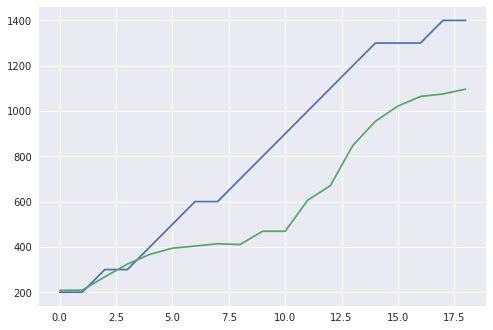

In [166]:
plt.plot(y_test_org[0])
plt.plot(y_pred_org[0])

/home/user/env_py3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


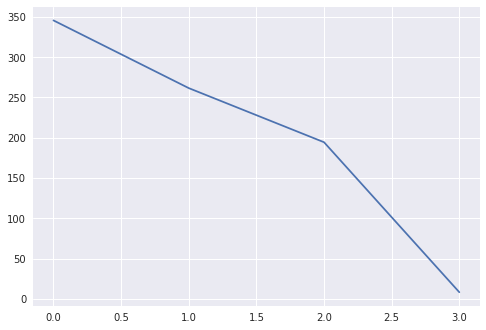

In [167]:
plt.plot(k)

### Model Feature Importances:

In [93]:
def util_feature_importances(classifier):
    print(classifier)
    dict_importance ={}
    for i in range(len(X_col)):
        dict_importance[X_col[i]] = classifier.feature_importances_[i]
        dict_importance_sort = sorted(dict_importance.items(), key=operator.itemgetter(1), reverse=True)
    return dict_importance_sort

In [168]:
util_feature_importances(classifier_ET)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=1, oob_score=False,
          random_state=<mtrand.RandomState object at 0x7f9fd17567e0>,
          verbose=0, warm_start=False)


[('increment.curr.mth', 0.27350885620482601),
 ('increment.curr.mth.d.Avg.Low.prev.mth', 0.17994530686870899),
 ('MV.3sec.curr', 0.11134565423642984),
 ('MV.3sec.curr.d.Avg.Low.prev.mth', 0.07875363278478574),
 ('bid.sec', 0.075236355057414675),
 ('MV.5sec.curr', 0.067889138713852437),
 ('MV.5sec.curr.d.Avg.Low.prev.mth', 0.030547225235007847),
 ('MV.3sec.prev', 0.018722667794797108),
 ('increment.prev.mth', 0.017750733778730488),
 ('MV.5sec.prev', 0.016163566041785545),
 ('MV.3sec.prev.d.Avg.Low.prev.mth', 0.013074239647165854),
 ('Volume.Bidder.curr.mth', 0.010414478213625232),
 ('success.ratio.curr.mth', 0.010208643616370739),
 ('MV.5sec.prev.d.Avg.Low.prev.mth', 0.0099959318987957561),
 ('Volume.Plate.curr.mth', 0.008539071361048511),
 ('success.ratio.prev.mth', 0.0084049750525541124),
 ('d.success.ratio', 0.0082291780819245021),
 ('d.Avg.Low.prev.mth', 0.0075112083604783339),
 ('d.Volume.Plate', 0.0072352139232875409),
 ('bid.curr.mth', 0.0072036187423227382),
 ('Volume.Bidder.pre

In [169]:
util_feature_importances(classifier_GB)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.002, loss='ls', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1500, presort='auto',
             random_state=<mtrand.RandomState object at 0x7f9fd17567e0>,
             subsample=1.0, verbose=0, warm_start=False)


[('increment.curr.mth.d.Avg.Low.prev.mth', 0.29351956032430798),
 ('MV.3sec.prev.d.Avg.Low.prev.mth', 0.083915983098903163),
 ('bid.sec', 0.072789659040464805),
 ('MV.5sec.prev.d.Avg.Low.prev.mth', 0.066352003045957661),
 ('Volume.Bidder.curr.mth', 0.057499696748986508),
 ('increment.curr.mth', 0.057354004634974372),
 ('d.Volume.Plate', 0.055883321614265576),
 ('d.Avg.Low.prev.mth', 0.047149125650616103),
 ('increment.prev.mth', 0.039561783435570062),
 ('Volume.Plate.curr.mth', 0.034932161719615461),
 ('MV.3sec.prev', 0.029217941652515865),
 ('MV.3sec.curr', 0.028531907998787971),
 ('MV.5sec.curr', 0.023095885032380414),
 ('bid.prev.mth', 0.019877015014114579),
 ('success.ratio.curr.mth', 0.019287322937067083),
 ('month', 0.013250541072941033),
 ('MV.3sec.curr.d.Avg.Low.prev.mth', 0.010760492385241646),
 ('bid.curr.mth', 0.0078716254653724924),
 ('MV.5sec.prev', 0.0067208197429068552),
 ('d.Volume.Bidder', 0.0064726479050874371),
 ('MV.5sec.curr.d.Avg.Low.prev.mth', 0.00622733182878834

---

### The End